# INF552 Homework3:

Student Name : Hsin-Yu, Chang (1160173733)

## 1. Time Series Classification

__>__ Using f1-score to evaluate every model in the following questions.

In [241]:
import numpy as np
import pandas
import urllib.request
import zipfile
import re

In [3]:
def findsep(fd):
    firstNlines=fd.readlines()[5]
    fd.close
    return firstNlines[1] #whitespace=32, comma=44   

In [4]:
feature = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00366/AReM.zip'
zipname = 'AReM.zip'
urllib.request.urlretrieve(url, zipname)
csvfile = [csv for csv in zipfile.ZipFile(zipname).namelist() if 'csv' in csv]


#bending2/dataset4.csv > whitespace seperator
#cycle/dataset9.csv > ending comma
#cycle/dataset14.csv > ending comma

### (a)  Download AReM Data

In [8]:
def loaddata(csvfile, l):
    describe = ['mean', 'std', 'min','_1stquart_', 'median', '_3rdquart_', 'max']
    desorder = [des+str(i) for i in range(1,6*l+1) for des in describe]
    arem = pandas.DataFrame(columns = desorder+['activity', 'fileindex'])

    for i, csv in enumerate(csvfile):
        with open('AReM/'+ csv) as csvfd:
            sep = findsep(csvfd)
            if sep == 32 or sep == ' ' :
                instance = pandas.read_csv('AReM/'+ csv, skiprows = 5, sep='\s+', header = None)
            else:
                instance = pandas.read_csv('AReM/'+ csv, skiprows=5, header = None)
        instance.columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        
        splitlen = int(instance.shape[0]/l)+1
        
        instdes = []
        for time in range(l):
            instancecut = instance.iloc[:min(splitlen,instance.shape[0])] 
            instance = instance.drop(instance.index[:min(splitlen,instance.shape[0])])  
            describe = instancecut.describe().drop('count').drop(columns = '# Columns: time').T
            #long to wide
            for row in describe.index:
                instdes.extend(describe.loc[row].tolist())
        
        instdes.extend([re.split('/', csv)[0],re.search('dataset(.*).csv', re.split('/', csv)[1]).group(1)])
        arem.loc[str(i)] = instdes

   
    feature = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    colorder = [fea+str(i) for i in range(1,6*l+1) for fea in feature]+['activity', 'fileindex']
    arem = arem.loc[:,colorder]
    return arem

### (b) Split into Train and Test data

In [17]:
def traintestsplit(data):
    #test
    test = data.loc[(data.activity.str.contains('bending')) & (data.fileindex.isin(['1','2']))].drop(columns = 'fileindex')
    #train
    train = data.loc[(data.activity.str.contains('bending')) & (~data.fileindex.isin(['1','2']))].drop(columns = 'fileindex')        
    #test 
    test = pandas.concat([test, 
                          data.loc[(~data.activity.str.contains('bending')) & (data.fileindex.isin(['1','2','3']))].drop(columns = 'fileindex')])
    #train
    train = pandas.concat([train,
                           data.loc[(~data.activity.str.contains('bending')) & (~data.fileindex.isin(['1','2','3']))].drop(columns = 'fileindex')])
    return train, test    

In [18]:
def xysplit(data):
    train, test = traintestsplit(data)
    train = train.assign(bending = list(train.loc[:,'activity'].str.contains('bending'))).drop(columns = 'activity')
    train.reset_index(drop=True, inplace=True) 
    #trainy = train.loc[:,'activity'].str.contains('bending').to_frame() #Series to dataframe
    #trainy.columns = ['bending']
    trainx = train.drop(columns = 'bending')
    trainy = train.loc[:,'bending'].values

    test = test.assign(bending = list(test.loc[:,'activity'].str.contains('bending'))).drop(columns = 'activity')
    test.reset_index(drop=True, inplace=True) 
    #testy = test.loc[:,'activity'].str.contains('bending').to_frame() 
    #testx = test.drop(columns = 'activity')
    testx = test.drop(columns = 'bending')
    testy = test.loc[:,'bending'].values
    return train, trainx, trainy, test, testx, testy 

__\>__ Demo of loading AReM data

In [228]:
arem1 = loaddata(csvfile, 1)

In [229]:
arem1.head(5)

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,activity,fileindex
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.00,0.0,1.30,0.358604,...,36.00,0.0,1.92,0.570583,0.43,0.582915,0.0,1.30,bending1,1
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.67,0.0,1.22,0.372438,...,34.50,0.0,3.11,0.571083,0.43,0.601010,0.0,1.30,bending1,2
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,36.50,0.0,1.79,0.493292,0.43,0.513506,0.0,0.94,bending1,3
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,36.33,0.0,2.18,0.613521,0.50,0.524317,0.0,1.00,bending1,4
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,31.25,0.0,1.79,0.383292,0.43,0.389164,0.0,0.50,bending1,5


In [230]:
ttrain, trainx, trainy, test, testx, testy = xysplit(arem1) 

In [231]:
ttrain.head()

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,bending
0,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94,True
1,33.00,47.75,42.179813,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00,True
2,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50,True
3,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87,True
4,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555313,0.49,0.487826,0.00,0.83,True


In [22]:
arem1.shape

(88, 44)

In [23]:
ttrain.shape

(69, 43)

In [24]:
test.shape

(19, 43)

### (c) Feature Extraction

#### i. Research the types of time domain features

__\>__ In classification of time series, time-domain features include descriptive statistics, such as mean, standard deviation, maximum, minimum and kth quartile. Futhermore, skewness and frequencies of peak in amplitude in discrete fourier transform are also used in times series classification.

#### ii. Extract the time-domain features

__\>__ I extract these features at the same time when I load AReM file into python, as I show above in question 1.(b)

In [25]:
ttrain.head(5)

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,bending
0,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94,True
1,33.00,47.75,42.179813,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00,True
2,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50,True
3,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87,True
4,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555313,0.49,0.487826,0.00,0.83,True


#### iii. Estimation of the standard deviation of each time-domain features and 90% Bootstrap Confidence Interval 

In [26]:
trainx.describe().loc['std']

min1           8.794295
max1           4.429182
mean1          4.917717
median1        4.956111
std1           1.758629
_1stquart_1    5.731262
_3rdquart_1    4.783645
min2           0.000000
max2           5.147841
mean2          1.600661
median2        1.436903
std2           0.902769
_1stquart_2    0.952201
_3rdquart_2    2.158258
min3           3.053869
max3           4.759853
mean3          3.863304
median3        3.845730
std3           0.996008
_1stquart_3    4.145255
_3rdquart_3    3.946023
min4           0.000000
max4           2.302408
mean4          1.179781
median4        1.149585
std4           0.473525
_1stquart_4    0.842771
_3rdquart_4    1.566564
min5           5.368786
max5           5.449726
mean5          5.120513
median5        5.267414
std5           1.057973
_1stquart_5    5.543882
_3rdquart_5    4.957231
min6           0.051766
max6           2.540166
mean6          1.171306
median6        1.104626
std6           0.519377
_1stquart_6    0.774233
_3rdquart_6    1

In [144]:
trainx.columns[trainx.describe().loc['std']>5]

Index(['min1', '_1stquart_1', 'max2', 'min5', 'max5', 'mean5', 'median5',
       '_1stquart_5'],
      dtype='object')

__\>__ describe( ) function calculates the corrected sample standard deviation. <br>There are more variant between all instance in time serie 5, with most of the descriptive statistics of this time-serie having large variance.

#### 90% Bootstrap Confidence Interval

In [232]:
from sklearn.utils import resample
def bootstrap(data, formula, loop, low, upper):  
    bootestimate = pandas.DataFrame(columns = list(data.columns))
    for i in range(loop):
        boot = resample(data, replace=True, n_samples=data.shape[0])
        bootestimate = bootestimate.append(boot.apply(formula, ddof=1, axis = 0), ignore_index=True) #series into dataframe
    interval = bootestimate.apply(np.percentile, args=([low,upper],), axis = 0)
    ci = pandas.Series([(round(interval.loc[0,col], 2), round(interval.loc[1,col],2)) for col in list(data.columns)], index=list(data.columns))    
    return ci

In [233]:
bootstrap(trainx, np.std, 1000, 5,95)

min1           (7.54, 10.0)
max1            (3.27, 5.4)
mean1          (4.32, 5.41)
median1        (4.32, 5.46)
std1           (1.55, 1.95)
_1stquart_1    (5.13, 6.19)
_3rdquart_1    (3.89, 5.53)
min2             (0.0, 0.0)
max2           (4.66, 5.53)
mean2           (1.4, 1.74)
median2        (1.24, 1.58)
std2           (0.81, 0.96)
_1stquart_2    (0.82, 1.05)
_3rdquart_2     (1.9, 2.34)
min3           (2.82, 3.23)
max3            (3.98, 5.4)
mean3          (3.17, 4.39)
median3         (3.13, 4.4)
std3           (0.76, 1.21)
_1stquart_3    (3.47, 4.66)
_3rdquart_3    (3.24, 4.51)
min4             (0.0, 0.0)
max4           (2.05, 2.51)
mean4          (1.08, 1.24)
median4        (1.05, 1.21)
std4           (0.43, 0.51)
_1stquart_4    (0.77, 0.89)
_3rdquart_4    (1.44, 1.64)
min5           (3.53, 6.87)
max5           (4.28, 6.35)
mean5          (3.73, 6.32)
median5        (3.81, 6.54)
std5            (0.8, 1.27)
_1stquart_5     (4.12, 6.8)
_3rdquart_5     (3.68, 6.1)
min6            (0.0

__\>__ I use 1000 resample AReM data to build the 90% Bootstrap Confidence Interval with lower and upper region equal to 5%.

#### iiii. Selection of the three most important time-domain features

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'time-domain features in row, time series in column')

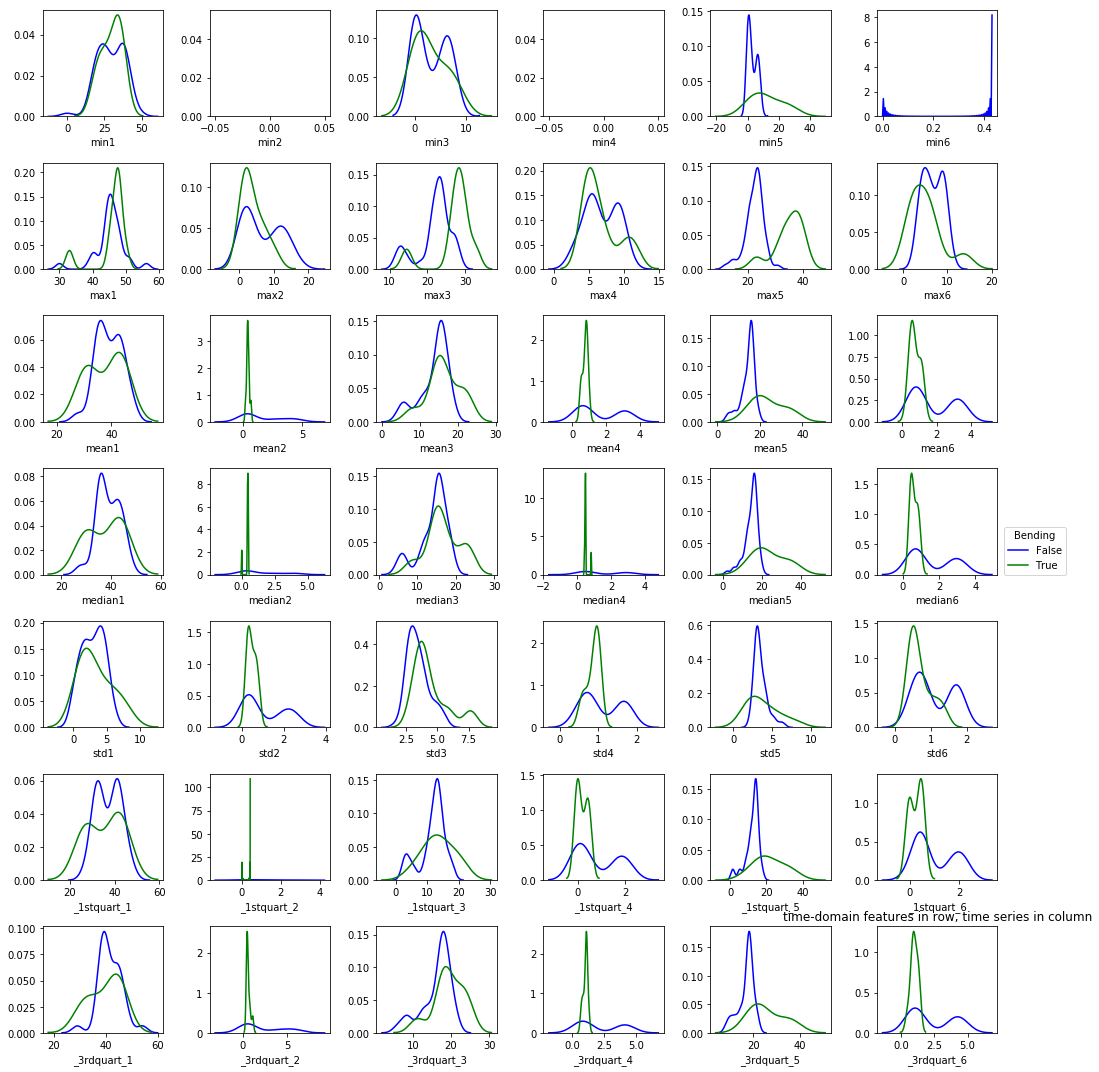

In [234]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,15))
for j, fea in enumerate(feature, start = 1):
    for i in range(1,7):    
        plt.subplot(7,6,6*j+i-6)
        sns.distplot(ttrain.loc[~ttrain.bending][fea+str(i)], kde = True, hist = False, color="blue", label="False")
        sns.distplot(ttrain.loc[ttrain.bending][fea+str(i)] , kde = True, hist = False, color="green", label="True")
        #train.groupby('bending')[fea+str(i)].hist(alpha=0.4)
        plt.legend().set_visible(False)
        if 6*j+i-6 == 24: 
            plt.legend(title = 'Bending',loc=(1.05,0))
plt.tight_layout()
plt.title('time-domain features in row, time series in column')

__\>__ My judgement would be choosing the features with a more obvious seperated distribution under different activities, taking 'bending' class as example. The plot show same time-domain feature in row for each time serie (in column). Based on my judgement, 'max', 'mean' and '3rd quartile' are the three most important time-domain features having a more seperated distribution shown above.

### (d) Binary Classification Using Logistic Regression

#### i. Scatterplot of the three most important time-domain features of time series 1, 2, and 6

In [32]:
def pairplot(data):
    difeature = [fea+str(i) for i in [1,2,6] for fea in ['max', 'mean', '_3rdquart_']]
    didata = data[difeature+['bending']]
    didata['bending']*=1
    return sns.pairplot(didata, hue='bending')#, diag_kind='hist')

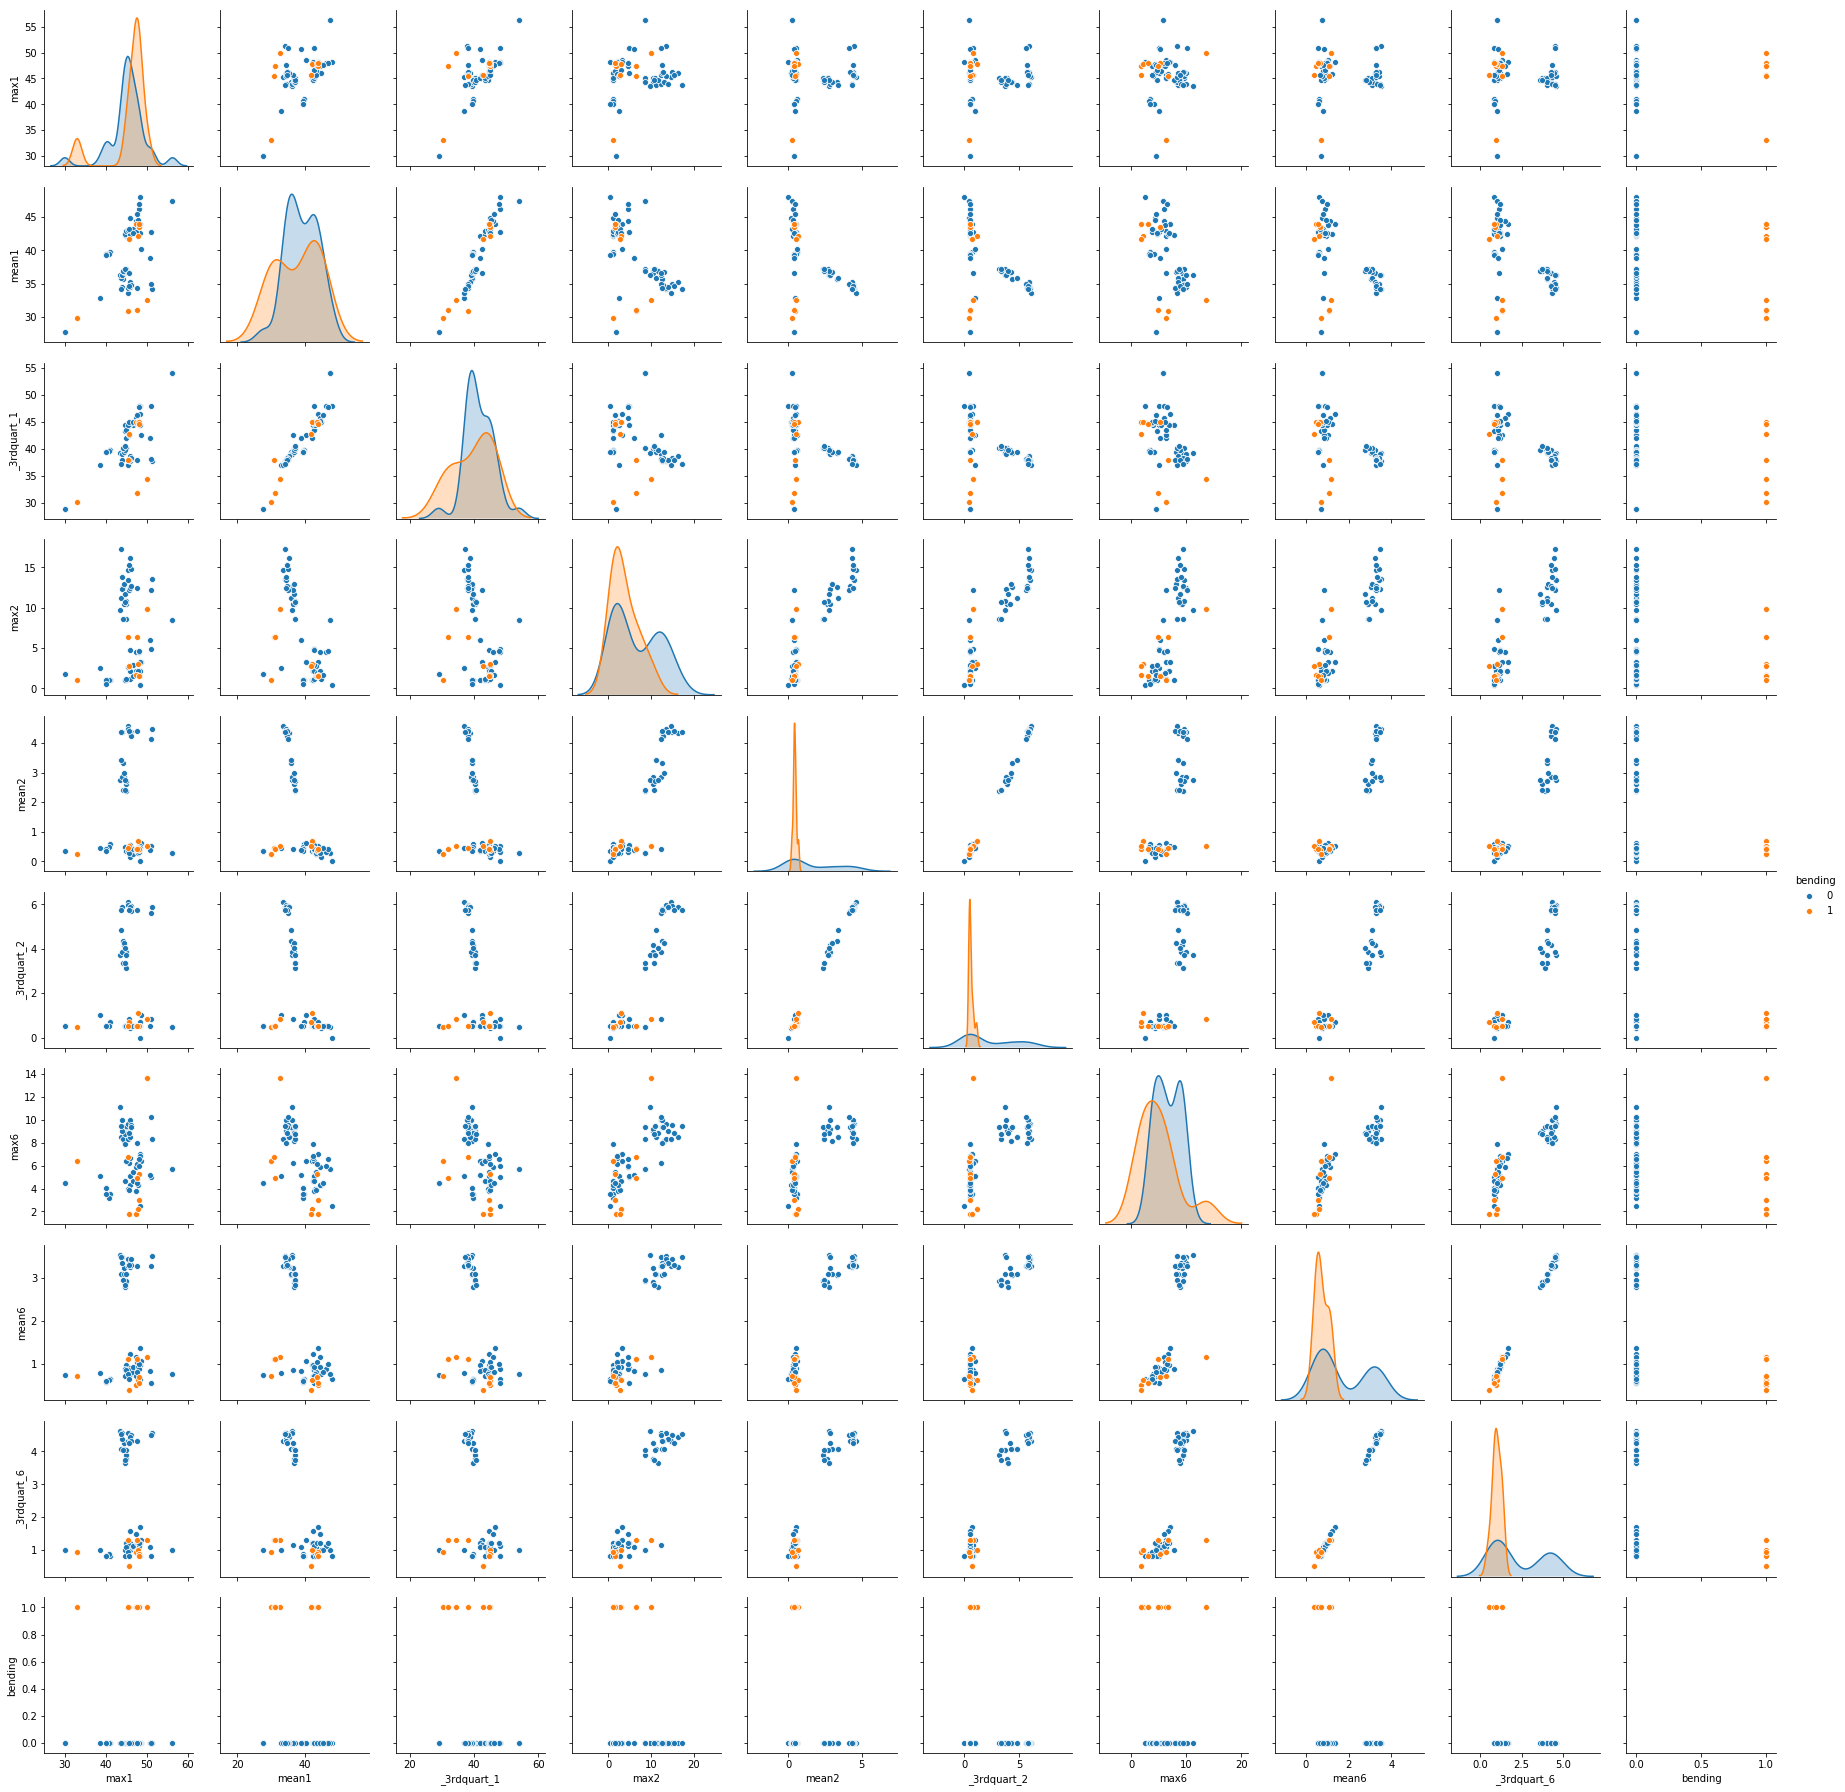

In [33]:
pairplot(ttrain)

#### ii. Scatterplot of the three most important time-domain features with time series 1, 2, and 6 break into 2 equal lenth time

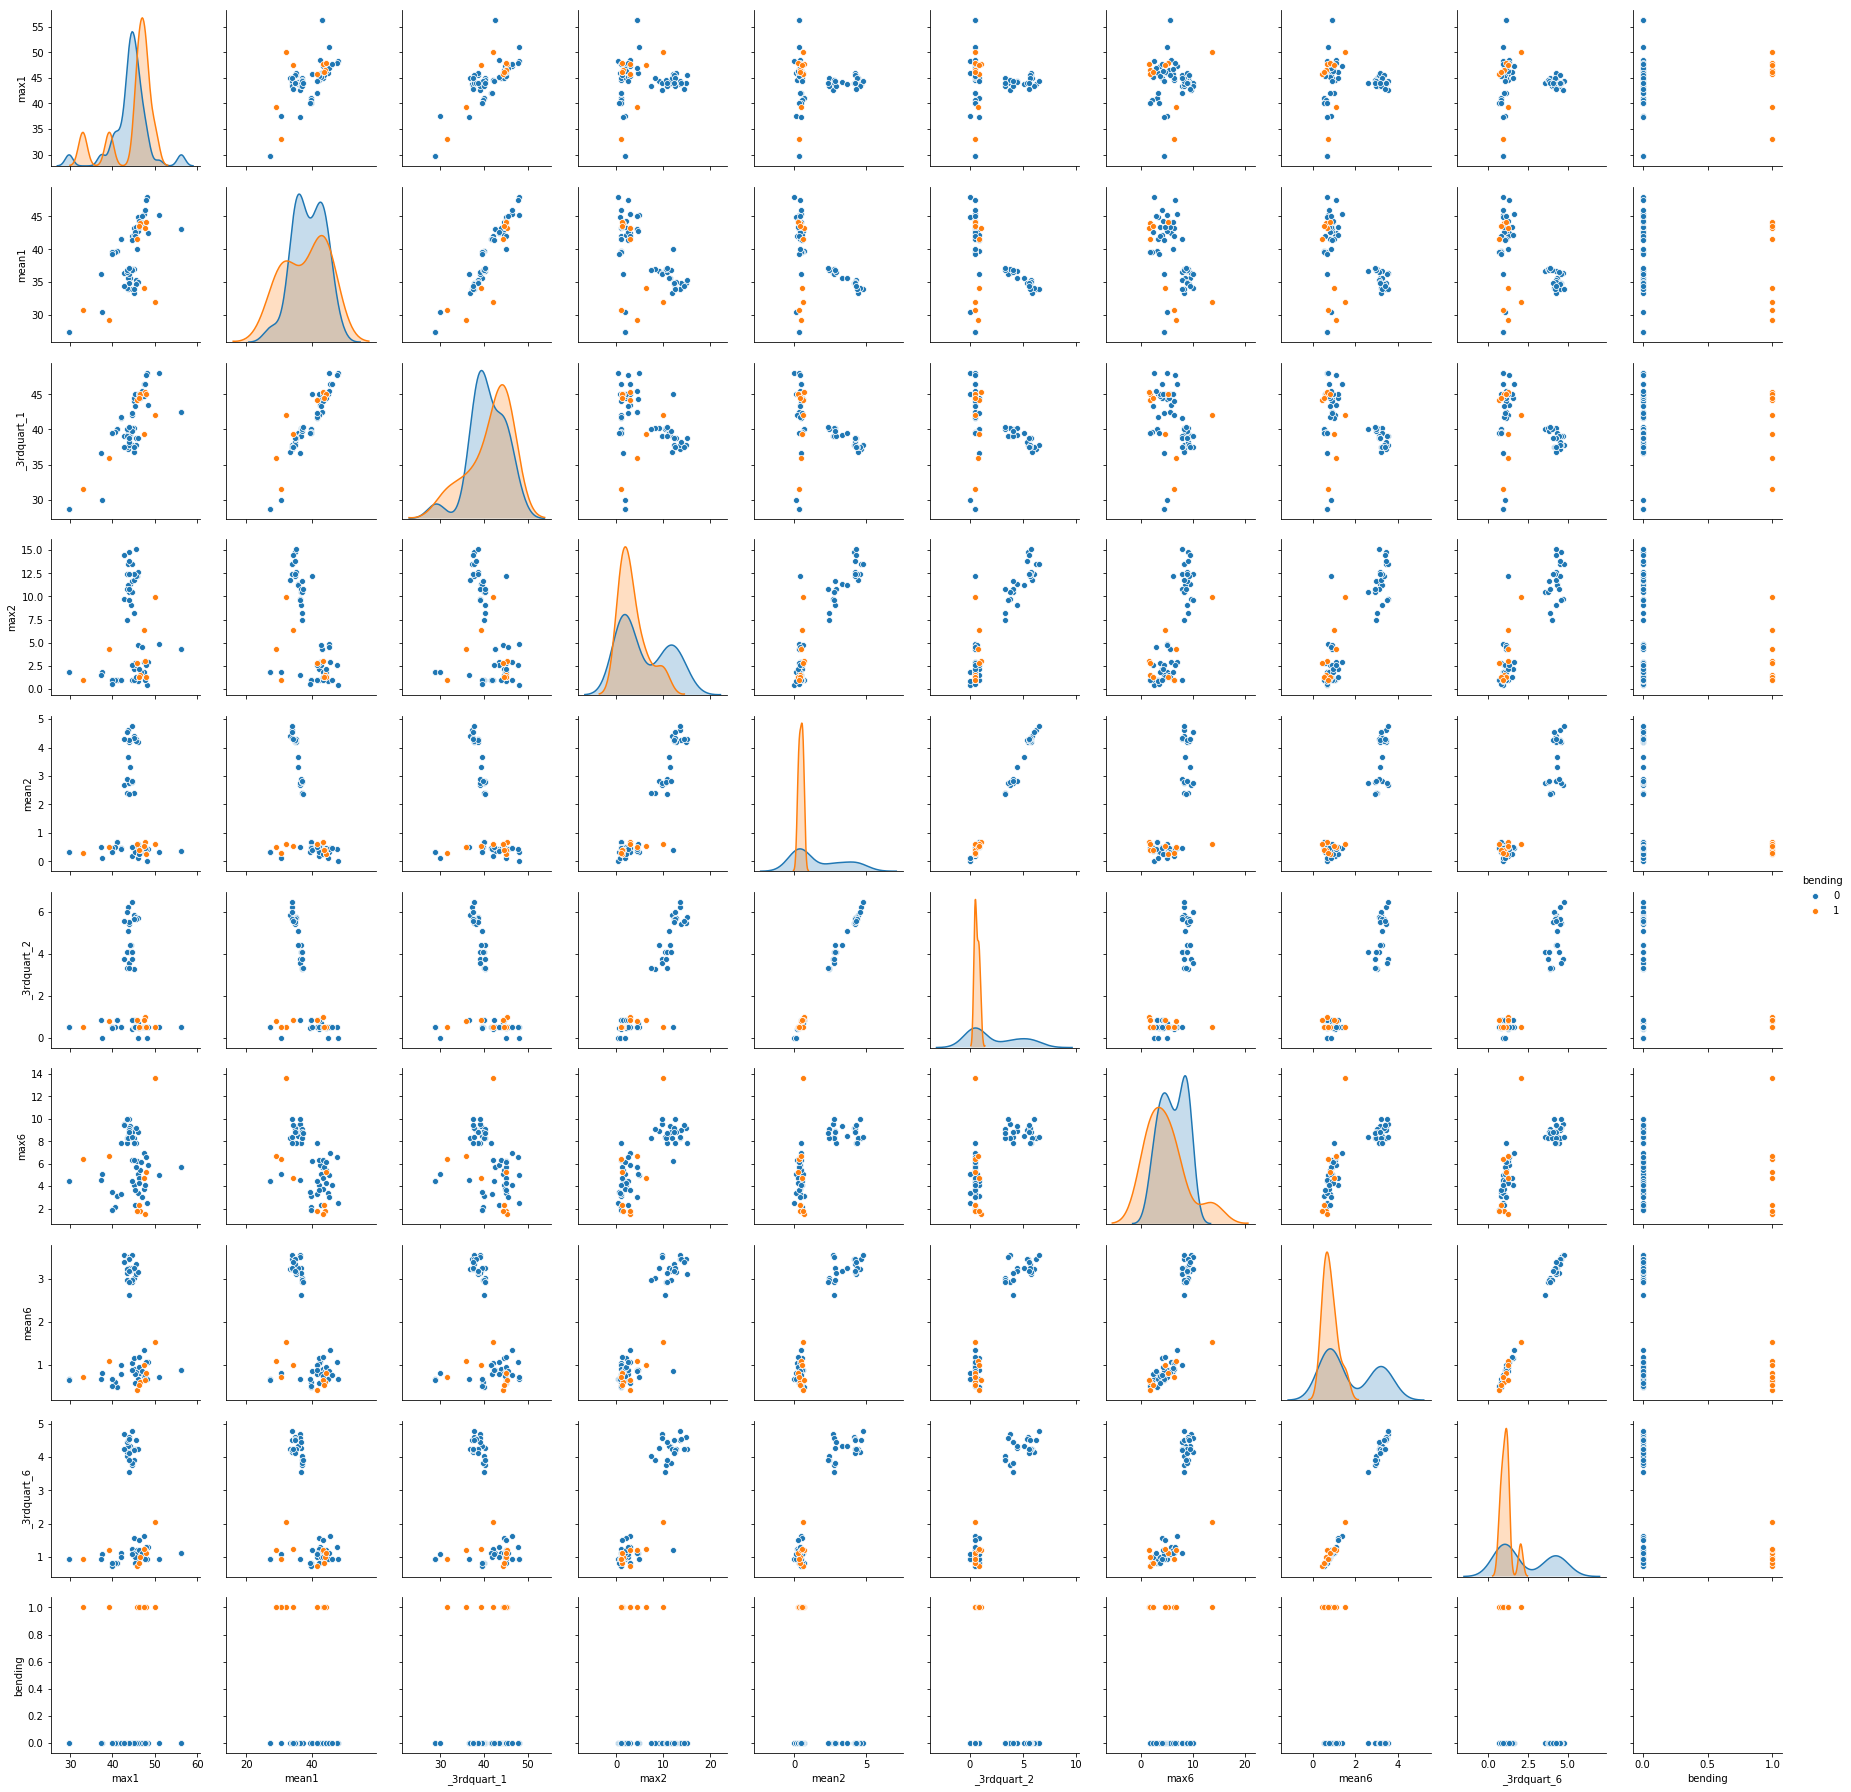

In [34]:
arem2 = loaddata(csvfile, 2)
train2, trainx2, trainy2, test2, testx2, testy2 = xysplit(arem2) 
pairplot(train2)

__\>__ In this question, we break time series into 2 equal time length, the scatterplots of time-domain features of series 1, 2 and 6 become more sparse than orignial, because the whole period in 1 length-time data breaks into 2 periods in 2 length-time data. Series 1, 2 and 6 in 2-length data now only capture the first period of the whole series in the original. However, the overall pattern in 2 equal time-length plot remains, like the one in whole time-length plot, which means even though we break the times series into 2 length, first time length still has similar pattern like the overall but more sparse. From the distribution of each time-domain features in 2 time-length scatterplot, there are slightly difference, but overall it looks similar with the whole time length.  

#### iii. Find best number of equal length to break time series

In [35]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import statsmodels.api as sm
import math

In [36]:
def LogicRegrl(l):
    cvf1 = []
    for l in range(1,l+1):
        arem = loaddata(csvfile, l)
        ttrain, trainx, trainy, test, testx, testy = xysplit(arem)
        #over sample
        #smote = RandomOverSampler()
        #trainx, trainy = smote.fit_sample(trainx, trainy)
        #trainx = {testx.columns[i]: trainx[:,i] for i in range(len(testx.columns))}
        #trainx = pandas.DataFrame.from_dict(trainx)        
        cvf1.append(cv(trainx, trainy))
    return pandas.Series(cvf1, index=[ l for l in range(1,l+1)])

In [37]:
def cv(trainx, trainy):
    f1score = []
    fold = 5
    logitRegr = LogisticRegression(max_iter=10, C=10000)
    
    cv = StratifiedKFold(n_splits=fold, shuffle = True)
    cv.get_n_splits(trainx, trainy)
    for traini, validi in cv.split(trainx, trainy):
        rfecv = RFECV(logitRegr, step=1, cv=StratifiedKFold(n_splits=fold, shuffle = True), scoring='accuracy')
        rfecv = rfecv.fit(trainx.loc[traini], trainy[traini])
        refit = logitRegr.fit(trainx.loc[traini][trainx.columns[rfecv.support_].tolist()], trainy[traini])
        predy = refit.predict(trainx.loc[validi][trainx.columns[rfecv.support_].tolist()])
        f1score.append(f1_score(trainy[validi], predy, average='weighted'))    
    return np.mean(f1score)

In [38]:
l=20
import warnings
warnings.filterwarnings('ignore')
LogicRegrl = LogicRegrl(l)

In [39]:
LogicRegrbestl = np.array([ l for l in range(1,l+1)])[LogicRegrl.values == max(LogicRegrl.values)][0]
#LogicRegrbestl = 1, 0.986832

__>__ In this question, we break our training dataset into 5 folds, and build logistic regression with feature selection on train part and use validation part to validate our training model. The wrong way for this is that we do feature selection with all training data before cv process at first, and use 5-fold cross validation to test our previous model. The problem of this way is that feature selection should include in cross validation, not outside the cv process. By doing the wrong way, the model we built in feature selection has already seen the validation data, which turns out to have a good performance in predicting validation data.

__>__ The best length for logistic regression with large cost to get rid of penalty (C=10000) is when we break data into one-length data, having cv f1-score = 0.986.

#### iv. Logistic Regressin with best length =1

In [235]:
#conda install -c r rpy2
import rpy2.robjects as robjects
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri

numpy2ri.activate()
pandas2ri.activate()

stats = importr('stats')
base = importr('base')


In [237]:
fold = 5
arem = loaddata(csvfile, LogicRegrbestl)
ttrain, trainx, trainy, test, testx, testy = xysplit(arem) 
logitRegr = LogisticRegression(max_iter=10, C=10000)
rfecv = RFECV(logitRegr, step=1, cv=StratifiedKFold(n_splits=fold, shuffle = True), scoring='accuracy')
rfecv = rfecv.fit(trainx, trainy)

__>__ The logistic regression built in glm in R does not apply penalty to high complexity model.

In [238]:
rtrain = pandas2ri.py2ri(ttrain[trainx.columns[rfecv.support_].tolist()+['bending']])
rtrainx = pandas2ri.py2ri(ttrain[trainx.columns[rfecv.support_].tolist()])
r.assign('rtrainx', rtrainx)
rtrainy = pandas2ri.py2ri(ttrain['bending'])
r.assign('rtrainy', rtrainy)

1,1,1,1,...,0,0,0,0


In [364]:
formula = robjects.Formula('bending~.')
rlogit = stats.glm(formula, family=r('binomial(link="logit")'),maxit = 10, data = rtrain)
predity = r.predict(rlogit, rtrainx, type = "response")

In [365]:
print(base.summary(rlogit).rx('coefficients'))

$coefficients
                Estimate Std. Error     z value  Pr(>|z|)
(Intercept)  -31.6707736 254.819813 -0.12428694 0.9010881
mean1         -1.4461380  12.756666 -0.11336332 0.9097425
X_3rdquart_1   1.0836830  13.674189  0.07925025 0.9368336
max2          -1.1228927   8.871910 -0.12656718 0.8992830
X_3rdquart_2   2.5842776  51.860505  0.04983132 0.9602568
median3       -0.8871669   7.770427 -0.11417222 0.9091013
min5           2.0721948  10.231619  0.20252853 0.8395036
max5           2.0658447   8.890604  0.23236268 0.8162563
mean5         -0.9611670  29.958310 -0.03208349 0.9744055
X_1stquart_5   0.1847405  16.085271  0.01148507 0.9908364
max6           1.0806301  13.314456  0.08116216 0.9353130
X_3rdquart_6  -4.4254532  65.331067 -0.06773888 0.9459935




__>__ From these parameters selecting from cross-validation recursive feature elimination, we can see that'mean', 'max' and '3rd quartile' are high ranking features, which means they play important role in model comparing to other features, meeting my judgement on the three most important time-domain feature in previous question, even though their p-value in modeling logistic regression do not seem to give us strong evidence to believe their relationship with the 'bending' activity.

In [366]:
predity = r.predict(rlogit, rtrainx)
#print('f1 score: %0.2f '%f1_score(trainy, predity, average='weighted'))
#confusion_matrix(trainy, predity)

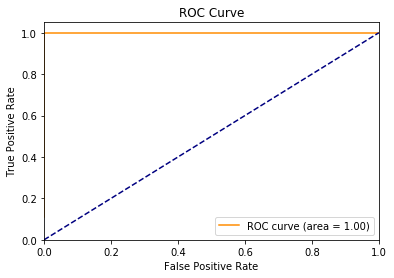

In [367]:
fpr, tpr, thresholds = roc_curve(trainy, predity, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [368]:
threshold =thresholds[np.sqrt((0-fpr)**2+(1-tpr)**2) == min(np.sqrt((0-fpr)**2+(1-tpr)**2))]

__>__ From ROC, I select the threshold which has the smallest distance with (fpr = 0, tpr = 1), and classify the test data with this threshold.

In [369]:
traink = np.array(predity) > threshold
print('f1 score: %0.2f '%f1_score(trainy, traink, average='weighted'))
confusion_matrix(trainy, traink)

f1 score: 0.99 


array([[60,  0],
       [ 1,  8]])

#### v. Test Logistic Regressin with best length = 1

In [370]:
rtestx = pandas2ri.py2ri(test[trainx.columns[rfecv.support_].tolist()])
r.assign('rtestx', rtestx)
rtesty = pandas2ri.py2ri(test['bending'])
r.assign('rtesty', rtesty)

1,1,1,1,...,0,0,0,0


In [371]:
predity = r.predict(rlogit, rtestx, type = "response")
testk = np.array(predity) > threshold
print('f1 score: %0.2f '%f1_score(testy, testk, average='weighted'))
confusion_matrix(testy, testk)

f1 score: 0.70 


array([[15,  0],
       [ 4,  0]])

__>__ The cv validation f1-score of length 1 in the question (d)iii. is average 0.986, it has huge difference comparing to the test f1-score = 0.7

__>__ Our logistic regression model with no penalty performs well in training data with f1-score = 0.99. However, it does not has the same performance on the test data, it turns out to have high tendency to class new datapoint to the 'non-bending' class. The reason for this might beacause of the imbalance class in our training data set, with only 9 'bending' datapoints out of 69 datapoints, which makes our model having problem with detecting 'bending' class pattern, and extract them. 

#### vi. Is the data well seperated?

__>__ Yes, as I first put the AReM data into modeling, there came error with max iteration, the reason for this is beacause of the well seperated characteristic in the data. Therefore, the number of max iteration needs to be set beforehand to avoid the error. 

#### vii. Build Logistic Regression with case-control sample

__>__ Use Smote Oversampling to fix the problem of imbalance class

In [372]:
arem = loaddata(csvfile, LogicRegrbestl)
ttrain, trainx, trainy, test, testx, testy = xysplit(arem)
#over sample
from imblearn.over_sampling import RandomOverSampler
smote = RandomOverSampler()
trainx, trainy = smote.fit_sample(trainx, trainy)
trainx = {testx.columns[i]: trainx[:,i] for i in range(len(testx.columns))}
trainx = pandas.DataFrame.from_dict(trainx)
ttrain = pandas.concat([trainx, pandas.DataFrame({'bending':trainy})], axis = 1)

In [393]:
fold = 5
logitRegr = LogisticRegression(max_iter=10, C=10000)
rfecv = RFECV(logitRegr, step=1, cv=StratifiedKFold(n_splits=fold, shuffle = True), scoring='accuracy')
rfecv = rfecv.fit(trainx, trainy)

In [394]:
rtrain = pandas2ri.py2ri(ttrain[trainx.columns[rfecv.support_].tolist()+['bending']])
r.assign('rtrain', rtrain)
rtrainx = pandas2ri.py2ri(ttrain[trainx.columns[rfecv.support_].tolist()])
r.assign('rtrainx', rtrainx)
rtrainy = pandas2ri.py2ri(ttrain['bending'])
r.assign('rtrainy', rtrainy)

1,1,1,1,...,1,1,1,1


##### Training Set

In [395]:
formula = robjects.Formula('bending~.')
rlogit = stats.glm(formula, family=r('binomial(link="logit")'),maxit = 10, data = rtrain)
predity = r.predict(rlogit, rtrainx, type = "response")

In [396]:
print(base.summary(rlogit).rx('coefficients'))

$coefficients
               Estimate Std. Error      z value  Pr(>|z|)
(Intercept)   6.9688933 298.116003  0.023376448 0.9813500
min1         -0.3761000   2.020706 -0.186123039 0.8523483
mean1         0.4230456  21.367733  0.019798340 0.9842042
X_3rdquart_1 -1.2455090  21.618700 -0.057612577 0.9540572
max2         -1.1762290  17.210240 -0.068344718 0.9455112
X_3rdquart_2  5.7118714  63.795611  0.089533925 0.9286576
max3          3.0774507  17.287442  0.178016543 0.8587100
median3      -3.4617728  41.837675 -0.082742954 0.9340559
X_3rdquart_3  0.8085415  43.735859  0.018486923 0.9852504
X_3rdquart_4 -9.4208380 112.368166 -0.083839030 0.9331844
min5          1.5936546   8.275700  0.192570361 0.8472955
max5          0.5773610  10.072936  0.057318044 0.9542918
mean5        -2.2812496  18.088928 -0.126113037 0.8996424
X_1stquart_5  1.7980865  12.938913  0.138967362 0.8894759
max6         -0.1169657  24.491114 -0.004775843 0.9961894
X_3rdquart_6 -0.5488060 153.657651 -0.003571615 0.9971503


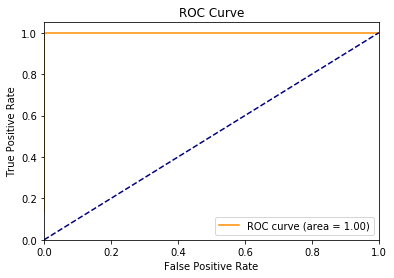

In [397]:
fpr, tpr, thresholds = roc_curve(trainy, predity, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [398]:
threshold =thresholds[np.sqrt((0-fpr)**2+(1-tpr)**2) == min(np.sqrt((0-fpr)**2+(1-tpr)**2))]

In [399]:
traink = np.array(predity) > threshold
print('f1 score: %0.2f '%f1_score(trainy, traink, average='weighted'))
confusion_matrix(trainy, traink)

f1 score: 0.98 


array([[60,  0],
       [ 2, 58]])

##### Test Set 

In [400]:
rtestx = pandas2ri.py2ri(test[trainx.columns[rfecv.support_].tolist()])
r.assign('rtestx', rtestx)
rtesty = pandas2ri.py2ri(test['bending'])
r.assign('rtesty', rtesty)

1,1,1,1,...,0,0,0,0


In [401]:
predity = r.predict(rlogit, rtestx, type = "response")
testk = np.array(predity) > threshold
print('f1 score: %0.2f '%f1_score(testy, testk, average='weighted'))
confusion_matrix(testy, testk)

f1 score: 1.00 


array([[15,  0],
       [ 0,  4]])

__>__ With a SMOTE oversampling process, we make the number of minor class equals to majority class. With this preprocessing, we still remain a good traing error, but we got a better test error (f1-score = 1) comparing using imbalance data (f1-score = 0.7). 

##### Use Step( ) in R with case-control sample 

The step( ) module in R uses AIC as the criteria for backward selection.<br>__>__ I am just doing it to see if there is a difference comparing to the recursive feature selection in python.

In [424]:
formula = robjects.Formula('bending~.')
rlogit = stats.glm(formula, family=r('binomial(link="logit")'),maxit = 10, data = rtrain)
step = stats.step(rlogit,direction="backward", trace=False, test = "F")

In [425]:
print(r.formula(step))

bending ~ max1 + X_3rdquart_1 + mean5



##### Training Set

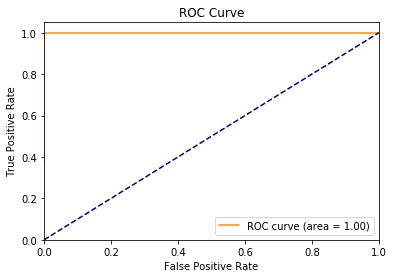

In [428]:
formula = robjects.Formula('bending ~ max1 + X_3rdquart_1 + mean5')
steplogit = stats.glm(formula, family=r('binomial(link="logit")'),maxit = 10, data = rtrain)
predity = r.predict(steplogit, rtrainx, type = "response")

fpr, tpr, thresholds = roc_curve(trainy, predity, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [429]:
print(base.summary(steplogit).rx('coefficients'))

$coefficients
                Estimate Std. Error   z value    Pr(>|z|)
(Intercept)  -122.531251  65.043068 -1.883848 0.059585543
max1            5.090374   2.182123  2.332762 0.019660625
X_3rdquart_1  -10.242382   3.995398 -2.563545 0.010360942
mean5          15.460618   5.896214  2.622127 0.008738298




__>__ Step( ) in R gets a less complex backward model with only three predictors involved, but even though with a less complex model, it still performs quite well in prediction. Furthermore, it also gives us supportive evidence about the relationship between the predictors and the 'bending' class with p-value below 0.05. In sum, I think it is a good model compared with the previous one with RFECV, because of the simplicity and evidence which make our model more interpretable.

In [430]:
threshold =thresholds[np.sqrt((0-fpr)**2+(1-tpr)**2) == min(np.sqrt((0-fpr)**2+(1-tpr)**2))]

In [431]:
traink = np.array(predity) > threshold
print('f1 score: %0.2f '%f1_score(trainy, traink, average='weighted'))
confusion_matrix(trainy, traink)

f1 score: 0.95 


array([[60,  0],
       [ 6, 54]])

##### Test Set

In [433]:
predity = r.predict(steplogit, rtestx, type = "response")
testk = np.array(predity) > threshold
print('f1 score: %0.2f '%f1_score(testy, testk, average='weighted'))
confusion_matrix(testy, testk)

f1 score: 1.00 


array([[15,  0],
       [ 0,  4]])

### (e) Binary Classifiaction Using L1-penalized Logistic Regression

#### i. with L1-penalized Logistic Regression

__>__ I do scale preprocessing of my data and fit it into L1-penalized logistic regression.

In [43]:
import sys
sys.path
sys.path.append(r'/anaconda3/pkgs/liblinear-2.21/python')

In [44]:
import liblinear
from liblinearutil import *

In [48]:
from sklearn.datasets import dump_svmlight_file
from sklearn.datasets import load_svmlight_file

In [56]:
from sklearn.preprocessing import MinMaxScaler
def tL1LogicRegrl(l):
    cvf1 = []
    for l in range(1,l+1):
        areml = loaddata(csvfile, l)
        ttrain, trainx, trainy, test, testx, testy = xysplit(areml)
        
        y = ttrain.bending
        
        scaler = MinMaxScaler()
        scaltrainx = scaler.fit_transform(trainx)
        scaltrainx = pandas.DataFrame(scaltrainx)
        scaltrainx.columns = trainx.columns
      

        dump_svmlight_file(scaltrainx, y,'arem.dat',zero_based=True,multilabel=False)
        arem = load_svmlight_file("arem.dat")
        rX, ry = arem[0], arem[1]
        prob = problem(ry,  rX)
        acc = train(prob, '-s 6 -v 5')       
        cvf1.append(acc)
    
    return pandas.Series(cvf1, index=[ l for l in range(1,l+1)])

In [57]:
tL1LogicRegrl = tL1LogicRegrl(20)

In [58]:
tL1LogicRegrbestl = np.array([ l for l in range(1,l+1)])[tL1LogicRegrl.values == max(tL1LogicRegrl.values)][0]
#tL1LogicRegrbestl = 1, 91.304348

__>__ The best length for the L1-penalized logistic regression is 1, with cv f1-score = 0.91.

In [240]:
areml = loaddata(csvfile, tL1LogicRegrbestl)
ttrain, trainx, trainy, test, testx, testy = xysplit(areml)
        
y = ttrain.bending
scaler = MinMaxScaler()
scaltrainx = scaler.fit_transform(trainx)
scaltrainx = pandas.DataFrame(scaltrainx)
scaltrainx.columns = trainx.columns

dump_svmlight_file(scaltrainx, y,'arem.dat',zero_based=True,multilabel=False)
arem = load_svmlight_file("arem.dat")
rX, ry = arem[0], arem[1]
prob = problem(ry,  rX)
l1model = train(prob, '-s 6')       

##### Training Set

In [149]:
confusion_matrix(trainy, predy)

array([[60,  0],
       [ 2,  7]])

In [150]:
round(f1_score(trainy, predy, average='weighted'),2)

0.97

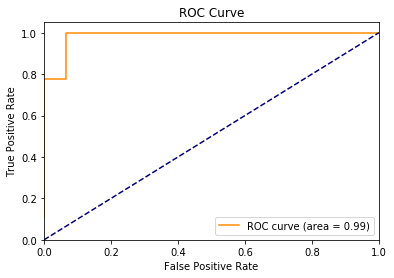

In [148]:
predy, predacc, predity = predict(ry, rX, l1model)
fpr, tpr, thresholds = roc_curve(trainy, predity, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Test Set

In [151]:
scaler = MinMaxScaler()
scaltestx = scaler.fit_transform(testx)
scaltestx = pandas.DataFrame(scaltestx)
scaltestx.columns = testx.columns

dump_svmlight_file(scaltestx, test.bending,'arem.dat',zero_based=True,multilabel=False)
aremt = load_svmlight_file("arem.dat")
tX, ty = aremt[0], aremt[1]

predy, predacc, predity = predict(ty, tX, l1model)
#print('f1 score: %0.2f '%f1_score(testy, predy, average='weighted'))
confusion_matrix(testy, predy)

array([[15,  0],
       [ 0,  4]])

In [152]:
round(f1_score(testy, predy, average='weighted'),2)

1.0

#### ii. Compare L1-penalized model with model with variable selection using p-value

__>__ This two model both turn out to have best cv f1-score when using 1-length time series, they both have good f1-score, but when it comes to the test set, model with L1-penaly performs much better than the other one (test f1-score = 0.7) which still remains good perdormance in test set (f1-score=1). 

__>__ As for implementation, L1-penalized model is more easy to deal with, beacuse when using feature selection with p-value in cross validation, it makes it more complex to put into practice.

### (f)  Multi-class Classification

In [71]:
def multixysplit(data):
    ttrain, test = traintestsplit(data)
    ttrain.reset_index(drop=True, inplace=True) 
    trainx = ttrain.drop(columns = 'activity')
    trainy = ttrain.loc[:,'activity'].values

    test.reset_index(drop=True, inplace=True) 
    testx = test.drop(columns = 'activity')
    testy = test.loc[:,'activity'].values
    return ttrain, trainx, trainy, test, testx, testy 

#### i. Find best l with L1-penalized Multinomial Regression

In [101]:
from sklearn.preprocessing import MinMaxScaler
def mL1LogicRegrl(l):
    cvf1 = []
    for l in range(1,l+1):
        areml = loaddata(csvfile, l)
        ttrain, trainx, trainy, test, testx, testy = multixysplit(areml)
        
        y = pandas.Categorical(ttrain.activity, categories =['bending1', 'bending2', 'cycling','lying','sitting','standing','walking']) 
        fy, _ = pandas.factorize(y)
        
        scaler = MinMaxScaler()
        scaltrainx = scaler.fit_transform(trainx)
        scaltrainx = pandas.DataFrame(scaltrainx)
        scaltrainx.columns = trainx.columns
        

        dump_svmlight_file(scaltrainx, fy,'arem.dat',zero_based=True,multilabel=False)
        arem = load_svmlight_file("arem.dat")
        rX, ry = arem[0], arem[1]
        prob = problem(ry,  rX)
        acc = train(prob, '-s 6 -v 5')       
        cvf1.append(acc)
    
    return pandas.Series(cvf1, index=[ l for l in range(1,l+1)])

In [102]:
l = 20
mL1LogicRegrl = mL1LogicRegrl(l)

In [103]:
mL1LogicRegrbestl = np.array([ l for l in range(1,l+1)])[mL1LogicRegrl.values == max(mL1LogicRegrl.values)][0]
#mL1LogicRegrbestl = 3, 69.565217

In [222]:
mL1LogicRegrbestl, max(mL1LogicRegrl.values)

(3, 69.56521739130434)

In [187]:
areml = loaddata(csvfile, mL1LogicRegrbestl)
ttrain, trainx, trainy, test, testx, testy = multixysplit(areml)
        
y = pandas.Categorical(ttrain.activity, categories =['bending1', 'bending2', 'cycling','lying','sitting','standing','walking']) 
fy, _ = pandas.factorize(y)
scaler = MinMaxScaler()
scaltrainx = scaler.fit_transform(trainx)
scaltrainx = pandas.DataFrame(scaltrainx)
scaltrainx.columns = trainx.columns

dump_svmlight_file(scaltrainx, fy,'arem.dat',zero_based=True,multilabel=False)
arem = load_svmlight_file("arem.dat")
rX, ry = arem[0], arem[1]
prob = problem(ry,  rX)
ml1model = train(prob, '-s 6') 


##### Training Set 

In [188]:
predy, predacc, predity = predict(ry, rX, ml1model)
activ = ['bending1', 'bending2', 'cycling','lying','sitting','standing','walking']
trainydum = np.array(pandas.get_dummies(trainy))
confusion_matrix(fy, predy)


array([[ 4,  0,  0,  0,  1,  0,  0],
       [ 1,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  1,  0],
       [ 0,  0,  0,  0, 11,  1,  0],
       [ 0,  0,  0,  0,  2, 10,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [189]:
round(f1_score(fy, predy, average='weighted'), 2)

0.91

In [190]:
from scipy import interp

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(len(activ)) :
    fpr[i], tpr[i], thresholds[i] = roc_curve(trainydum[:, i], np.array(predity)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#micro
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(trainydum.ravel(), np.array(predity).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#macro

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(activ))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(activ)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(activ)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

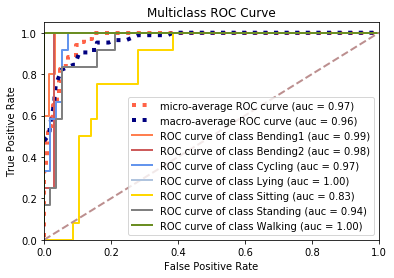

In [191]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (auc = %0.2f)'% roc_auc["micro"],
         color='tomato', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (auc = %0.2f)'% roc_auc["macro"],
         color='navy', linestyle=':', linewidth=4)

colors =['coral', 'indianred', 'cornflowerblue', 'lightsteelblue', 'gold', 'gray', 'olivedrab']
for i in range(len(activ)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class %s (auc = %0.2f)' % (activ[i].capitalize(), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--',color='rosybrown', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Test Set

In [192]:
ty = pandas.Categorical(test.activity, categories =['bending1', 'bending2', 'cycling','lying','sitting','standing','walking']) 
tfy, _ = pandas.factorize(ty)
scaler = MinMaxScaler()
scaltestx = scaler.fit_transform(testx)
scaltestx = pandas.DataFrame(scaltestx)
scaltestx.columns = testx.columns

dump_svmlight_file(scaltestx, tfy,'arem.dat',zero_based=True,multilabel=False)
arem = load_svmlight_file("arem.dat")
tX, ty = arem[0], arem[1]

predy, predacc, predity = predict(ty, tX, ml1model)
testydum = np.array(pandas.get_dummies(testy))

In [193]:
confusion_matrix(tfy, predy)

array([[2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 0, 0, 3]])

In [194]:
round(f1_score(tfy, predy, average='weighted'), 2)

0.84

In [195]:
from scipy import interp

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(len(activ)) :
    fpr[i], tpr[i], thresholds[i] = roc_curve(testydum[:, i], np.array(predity)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#micro
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(testydum.ravel(), np.array(predity).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#macro

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(activ))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(activ)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(activ)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



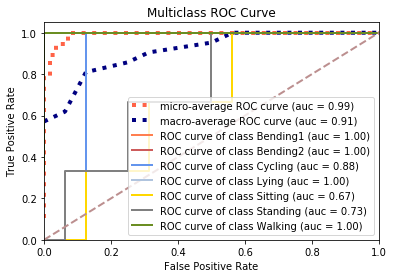

In [135]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (auc = %0.2f)'% roc_auc["micro"],
         color='tomato', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (auc = %0.2f)'% roc_auc["macro"],
         color='navy', linestyle=':', linewidth=4)

colors =['coral', 'indianred', 'cornflowerblue', 'lightsteelblue', 'gold', 'gray', 'olivedrab']
for i in range(len(activ)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class %s (auc = %0.2f)' % (activ[i].capitalize(), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--',color='rosybrown', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

__>__ Best length for L1-penalized model in multiclass classification is 3, which has approximate cv f1-score = 0.7 when building model. With the best length equals to 3, the refitting model has f1-score = 0.91 when dealing with training set, but has a lower f1-score in test set (f1-score = 0.84). AUC in 'sitting' and 'standing' are worse than other classes, which means model has a less ability to discriminate these two class comparing to other classes.

#### ii. Find best l with Naive Bayes classifier

#### 1. with Gaussian Naive Bayes classifier

In [68]:
from sklearn.naive_bayes import GaussianNB

In [72]:
def Gnbl(l):
    cvf1 = []
    for l in range(1,l+1):
        arem = loaddata(csvfile, l)
        ttrain, trainx, trainy, test, testx, testy = multixysplit(arem)
        f1score = []
        fold = 5
        gnb = GaussianNB()
    
        cv = StratifiedKFold(n_splits=fold, shuffle = True)
        cv.get_n_splits(trainx, trainy)
        for traini, validi in cv.split(trainx, trainy):
            gnb = gnb.fit(trainx.loc[traini], trainy[traini])
            predy = gnb.predict(trainx.loc[validi])
            f1score.append(f1_score(trainy[validi], predy, average='weighted')) 
        
        cvf1.append(np.mean(f1score))
    return pandas.Series(cvf1, index=[ l for l in range(1,l+1)])

In [73]:
l = 20
Gnbl = Gnbl(l)

In [220]:
Gnbbestl = np.array([ l for l in range(1,l+1)])[Gnbl.values == max(Gnbl.values)][0]
Gnbbestl, max(Gnbl.values)

(1, 0.8219677871148459)

In [196]:
#use best l to contruct Naive Bayes Classifier
arem = loaddata(csvfile, Gnbbestl)
ttrain, trainx, trainy, test, testx, testy = multixysplit(arem)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(trainx, trainy)


##### Training Set

In [209]:
predy = gnb.predict(trainx)
proby = gnb.predict_proba(trainx)
trainydum = np.array(pandas.get_dummies(trainy))

activ = gnb.classes_
activ = activ.tolist()
print('F1 score: ', f1_score(trainy, predy, average='weighted'))
confusion_matrix(trainy, predy)

array([[ 5,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [210]:
round(f1_score(trainy, predy, average='weighted'), 2)

1.0

In [203]:
from scipy import interp

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(len(activ)) :
    fpr[i], tpr[i], thresholds[i] = roc_curve(trainydum[:, i], proby[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#micro
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(trainydum.ravel(), proby.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#macro

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(activ))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(activ)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(activ)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



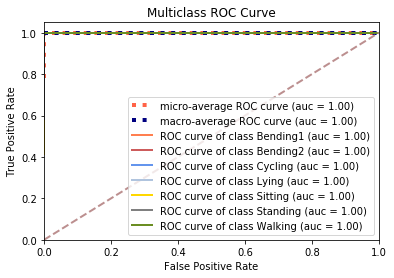

In [204]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (auc = %0.2f)'% roc_auc["micro"],
         color='tomato', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (auc = %0.2f)'% roc_auc["macro"],
         color='navy', linestyle=':', linewidth=4)

colors =['coral', 'indianred', 'cornflowerblue', 'lightsteelblue', 'gold', 'gray', 'olivedrab']
for i in range(len(activ)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class %s (auc = %0.2f)' % (activ[i].capitalize(), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--',color='rosybrown', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Test Set

In [205]:
predy = gnb.predict(testx)
proby = gnb.predict_proba(testx)
testydum = np.array(pandas.get_dummies(testy))

activ = gnb.classes_
activ = activ.tolist()
print('F1 score: ', f1_score(testy, predy, average='weighted'))
confusion_matrix(testy, predy)

array([[2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0],
       [0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 3]])

In [206]:
round(f1_score(testy, predy, average='weighted'), 2)

0.9

In [207]:
from scipy import interp

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(len(activ)) :
    fpr[i], tpr[i], thresholds[i] = roc_curve(testydum[:, i], proby[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#micro
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(testydum.ravel(), proby.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#macro

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(activ))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(activ)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(activ)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


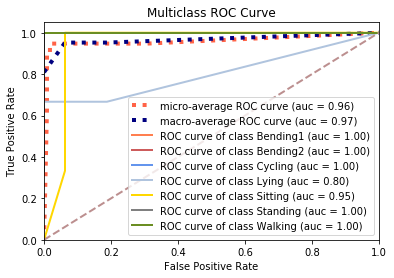

In [208]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (auc = %0.2f)'% roc_auc["micro"],
         color='tomato', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (auc = %0.2f)'% roc_auc["macro"],
         color='navy', linestyle=':', linewidth=4)

colors =['coral', 'indianred', 'cornflowerblue', 'lightsteelblue', 'gold', 'gray', 'olivedrab']
for i in range(len(activ)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class %s (auc = %0.2f)' % (activ[i].capitalize(), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--',color='rosybrown', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

__>__ Best length for Guassian Naive Bayes is 1, which have cv f1-score = 0.82. With best length, the confusion matrix built by Guassian Naive Bayes has overall f1 score = 1, it perform pretty well in most of the class, but when with 'lying' class, it have more tendency to predict in the wrong class, with auc=0.8.

#### 2. with Multinomial Naive Bayes classifier

In [80]:
from sklearn.naive_bayes import MultinomialNB
def Mnbl(l):
    cvf1 = []
    for l in range(1,l+1):
        arem = loaddata(csvfile, l)
        ttrain, trainx, trainy, test, testx, testy = multixysplit(arem)
        f1score = []
        fold = 5
        mnb = MultinomialNB()
    
        cv = StratifiedKFold(n_splits=fold, shuffle = True)
        cv.get_n_splits(trainx, trainy)
        for traini, validi in cv.split(trainx, trainy):
            mnb = mnb.fit(trainx.loc[traini], trainy[traini])
            predy = mnb.predict(trainx.loc[validi])
            f1score.append(f1_score(trainy[validi], predy, average='weighted'))         
        cvf1.append(np.mean(f1score))
    return pandas.Series(cvf1, index=[ l for l in range(1,l+1)])

In [81]:
l=20
Mnbl=Mnbl(l)
Mnbbestl = np.array([ l for l in range(1,l+1)])[Mnbl.values == max(Mnbl.values)][0]
#Mnbbestl = 1, 0.87

In [221]:
Mnbbestl, max(Mnbl.values)

(1, 0.8698217468805703)

In [211]:
#use best l to contruct Multinomial Naive Bayes Classifier
arem = loaddata(csvfile, Mnbbestl)
ttrain, trainx, trainy, test, testx, testy = multixysplit(arem)

from sklearn.naive_bayes import GaussianNB
mnb = MultinomialNB()
mnb = mnb.fit(trainx, trainy)


In [212]:
predy = mnb.predict(trainx)
proby = mnb.predict_proba(trainx)

trainydum = np.array(pandas.get_dummies(trainy))
activ = mnb.classes_
activ = activ.tolist()

confusion_matrix(trainy, predy)

array([[ 5,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  1,  0,  1, 10,  0,  0],
       [ 0,  0,  0,  0,  2, 10,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [213]:
round(f1_score(trainy, predy, average='weighted'),2)

0.93

In [214]:
from scipy import interp

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(len(activ)) :
    fpr[i], tpr[i], thresholds[i] = roc_curve(trainydum[:, i], proby[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#micro
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(trainydum.ravel(), proby.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#macro

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(activ))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(activ)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(activ)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

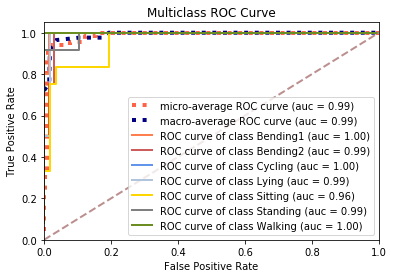

In [215]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (auc = %0.2f)'% roc_auc["micro"],
         color='tomato', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (auc = %0.2f)'% roc_auc["macro"],
         color='navy', linestyle=':', linewidth=4)

colors =['coral', 'indianred', 'cornflowerblue', 'lightsteelblue', 'gold', 'gray', 'olivedrab']
for i in range(len(activ)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class %s (auc = %0.2f)' % (activ[i].capitalize(), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--',color='rosybrown', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Test Set

In [216]:
predy = mnb.predict(testx)
proby = mnb.predict_proba(testx)

testydum = np.array(pandas.get_dummies(testy))
activ = mnb.classes_
activ = activ.tolist()

confusion_matrix(testy, predy)

array([[2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 3]])

In [217]:
round(f1_score(testy, predy, average='weighted'),2)

0.89

In [218]:
from scipy import interp

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(len(activ)) :
    fpr[i], tpr[i], thresholds[i] = roc_curve(testydum[:, i], proby[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#micro
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(testydum.ravel(), proby.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#macro

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(activ))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(activ)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(activ)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

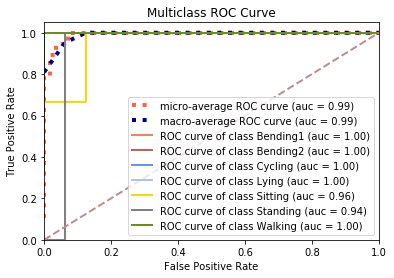

In [219]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (auc = %0.2f)'% roc_auc["micro"],
         color='tomato', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (auc = %0.2f)'% roc_auc["macro"],
         color='navy', linestyle=':', linewidth=4)

colors =['coral', 'indianred', 'cornflowerblue', 'lightsteelblue', 'gold', 'gray', 'olivedrab']
for i in range(len(activ)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class %s (auc = %0.2f)' % (activ[i].capitalize(), roc_auc[i]))

plt.plot([0, 1], [0, 1], '--',color='rosybrown', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

__>__ Best length for multinomial NB classifier is breaking time series into 1 equal time length with cross validation f1 score = 0.87. With best length, the confusion matrix built by multinomial Naive Bayes has overall f1-score = 0.89 when dealing with test data.

#### Conclusion of ii :

__>__ When choosing best length for these two NB classifier, Gaussian one have a more varying cv f1-score among different length comparing to multinomial one, it range from 0.47 to 0.82, it becomes weaker when we break the time series into more pieces, but multinomial one concentrates between 0.72 to 0.86. With this, I think when using Gaussian NB Classifer, if number of predictor is way more than the number of data points, it would have a weak performance.  


__>__ Both Naive Bayes Classifer perform well with test data, with roughly f1-score=0.9. These two classifier both have misclassification in some class, including 'sitting', 'standing' and 'lying' class, but Guassian one has a weaker performance in 'lying' class, with auc = 0.8.

#### iii. Conclusion for Multi-class Classification

__>__ Comparing the test error of these three classifiers, L1-penalized logistic regression has a weaker performance in predicting test dataset, in contrast, it has similar training error to others. I think using L1-penalized logistic regression might have more tendency to cause a more varying error comparing to two other Naive Bayes classifier. In sum, with multi-class classification, using Multinomial Naive Bayes Classifier is a more stable way to make prediction, taking the dimension of dataset (p>n) and test error into consideration.  